# Notebook evaluating metrics for particular node/edge configuration

In [2]:
# Imprt helper functions
# If new server on Descartes Labs, need to install rioxarray 
try: import rioxarray
except: 
    %pip install rioxarray
    
# Import helper functions
import helper_functions as hf
import netconf.netconf as nc

In [5]:
# Define variables
# Location variables
lat, lon, zoom = 33.893, 35.512, 14 # Map properties

# Building Footprints, damade assessments and interferogram file paths
buildingFile = "./data/beirutBuildingFootprints.geojson" # OSM data
assessmentFile = "./data/geopalData.csv" # GeoPal data
ifgPreFile = "./data/beirutPrePreExplosionIfg.tif" # SNAP output 1
ifgPostFile = "./data/beirutPrePostExplosionIfg.tif" # SNAP output 2
ifgBoth = True # If false, only uses prePost rather than difference between two

# A priori damage beliefs (green, yellow, red decisions)
decisions = {'GREEN (inspected) أخضر (تم دراسته)': False, 'YELLOW (restricted use) أصفر (لا يصلح للسكن)': True, 'RED (unsafe/evacuate) أحمر (غير آمن/للاخلاء)ء': True}
initBeliefs, confidence = [0.8,0.2], [0,0.9,1] # [noDmg, dmg], [Green,Yellow,Red]

# Edge creation
adjacent, geoNeighbours, ifgValues, neighbours = True, 4, True, 5

# Train/test split
testSplit, dmgThresh, stdTest, randomState = 0.3, 0.5, True, 42

# Classifications
targets = ['Undamaged', 'Damaged']

In [4]:
## Import Ground Data and combine
# Import footprints geojson
footprints = hf.import_OSM_fps(buildingFile)

# Import GeoPal assessments
assessments = hf.import_located_geopal_data(assessmentFile)

# Get joint geodataframe of building footprints with damage assessments
joint = hf.join_gdfs(footprints, assessments, column='decision')

# Display map of assessments upon which to draw Polygon for analysis
m1 = hf.create_map(lat, lon, zoom)
m1 = hf.plot_assessments(joint, m1)
m1, testPoly = hf.draw_polygon(joint, m1, stdTest)
m1

Map(center=[33.893, 35.512], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

In [6]:
# Import interferogram to dataframe
ifg, poly = hf.ifg_to_df(ifgPostFile, testPoly)

# If using both interferograms then subtract phase of second from first to get differecne
if ifgBoth: 
    ifgPre, _ = hf.ifg_to_df(ifgPreFile, testPoly)
    ifg = ifgPre-ifg

# Initialise beliefs for each pixel
initial = hf.init_beliefs(ifg, columns=['noDmg','dmg','ifg'], initBeliefs=initBeliefs)

# Split train/test set for located nodes
X_train, X_test, y_train, y_test = hf.train_test_split(joint, poly, column = 'decision')

# Create nodes
nodes = hf.create_nodes(initial, X_train)

# Assign prior beliefs from assessments
priors = hf.prior_beliefs(nodes, decisions, confidence, column = 'decision', beliefColumns = ['noDmg', 'dmg'])

# Create edges
edges = hf.create_edges(nodes, adjacent=adjacent, geo_neighbors=geoNeighbours, values=['ifg'] if ifgValues else False, neighbours=[neighbours])

In [7]:
# Run belief propagation
beliefs, _ = nc.netconf(edges,priors,verbose=True)

Nodes: 67210, Edges: 471004
It	max{del(B)}	del(label)

0	8.54195e-01		73

1	3.54101e-01		0

2	2.14445e-01		0

3	9.86038e-02		0

4	5.19843e-02		0

5	2.45000e-02		0

6	1.22231e-02		0

7	5.79676e-03		0

8	2.81864e-03		0

9	1.33805e-03		0

10	6.42298e-04		0

11	3.04743e-04		0

12	1.45303e-04		0

13	6.88816e-05		0

Time elapsed: 112.33781003952026 seconds


              precision    recall  f1-score   support

   Undamaged       0.99      1.00      0.99       954
     Damaged       0.00      0.00      0.00        11

    accuracy                           0.99       965
   macro avg       0.49      0.50      0.50       965
weighted avg       0.98      0.99      0.98       965



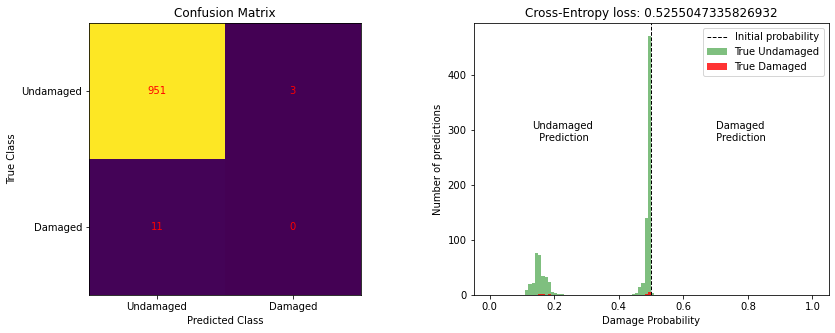

In [9]:
# Evaluation Metrics
# Get y_true vs y_pred for test set
y_true, y_pred = hf.get_labels(initial, X_test, beliefs, decisions, column='decision')

# Classification metrics
yp_clf, classes = hf.class_metrics(y_true, y_pred, targets, threshold=dmgThresh)

fig, axs = hf.create_subplots(1,2, figsize=[14,5])
# Confusion matrix
axs = hf.confusion_matrix(axs, y_true, yp_clf, classes)
  
# Cross entropy / Confidence metrics
axs = hf.cross_entropy_metrics(axs, y_true, y_pred, classes, dmgThresh, initBeliefs[1])

hf.show_plot()

In [10]:
# Save figure
hf.save_plot(fig, 'results/Beirut_adj{}_ifg{}{}'.format(str(adjacent),str(ifgValues),str(neighbours)))

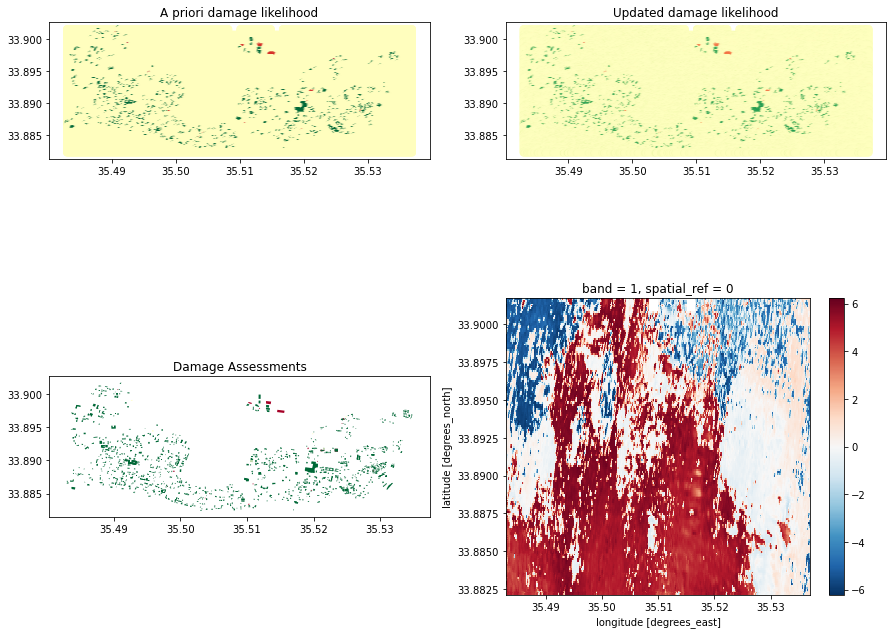

In [10]:
# Visualise spatial results
fig, axs = hf.create_subplots(2,2,figsize=[15,12])

prePlot = hf.belief_plot(nodes, axs[0,0], 'dmg', normalise=False)
postPlot = hf.belief_plot(nodes, axs[0,1], beliefs, normalise=True)
assessPlt = joint.loc[joint.within(poly)].plot(ax=axs[1,0], column='decision',cmap='RdYlGn_r')
ifgPlot = (hf.cropped_ifg(ifgPreFile,testPoly)-hf.cropped_ifg(ifgPostFile,testPoly)).plot(ax=axs[1,1])
prePlot.set_title('A priori damage likelihood'), postPlot.set_title('Updated damage likelihood'), assessPlt.set_title('Damage Assessments')

hf.show_plot()